In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Colab Notebooks/style_transfer/images"

ben_passmore.jpg  G0040288.JPG	magritte.jpg	   seaturtle2.JPG    whale1.jpg
cosmos.jpg	  hockney.jpg	octavia.jpg	   seaturtle.JPG     whale2.jpg
delaunay.jpg	  janelle.png	octopus.jpg	   sotomayor.jpg     whale3.jpg
dolphins.jpg	  kahlo.jpg	paintingallen.JPG  space_needle.jpg


# Style Transfer with Deep Neural Networks


In [0]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [0]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained = True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [6]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Loading Images



In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])


    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [0]:
path = "/content/drive/My Drive/Colab Notebooks/style_transfer/images"
content = load_image(path + '/dolphins.jpg').to(device)
style = load_image(path + '/whale3.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

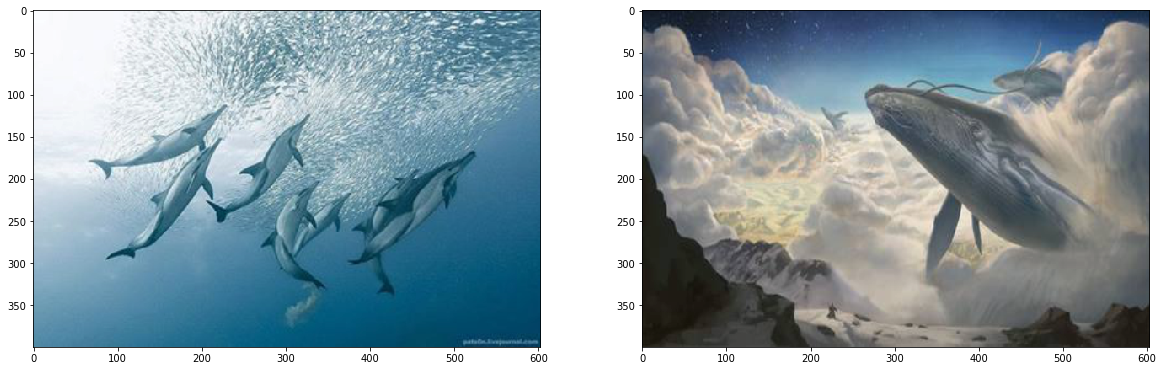

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2', 
                  '28': 'conv5_1'}
        
        

    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [0]:

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [0]:
# configure this a bit
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.9,
                 'conv3_1': 0.6,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# I leave this as it was from the lesson
content_weight = 1  # alpha
style_weight = 1e6  # beta

In [17]:

show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 10000 


for ii in range(1, steps+1):

    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    

    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        ## TODO: Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        ## TODO:  get the "style" style representation
        style_gram = style_grams[layer]
        ## TODO: Calculate the style loss for one layer, weighted appropriately
        layer_style_loss =  style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    ## TODO:  calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    ## -- do not need to change code, below -- ##
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    

    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Display the Target Image

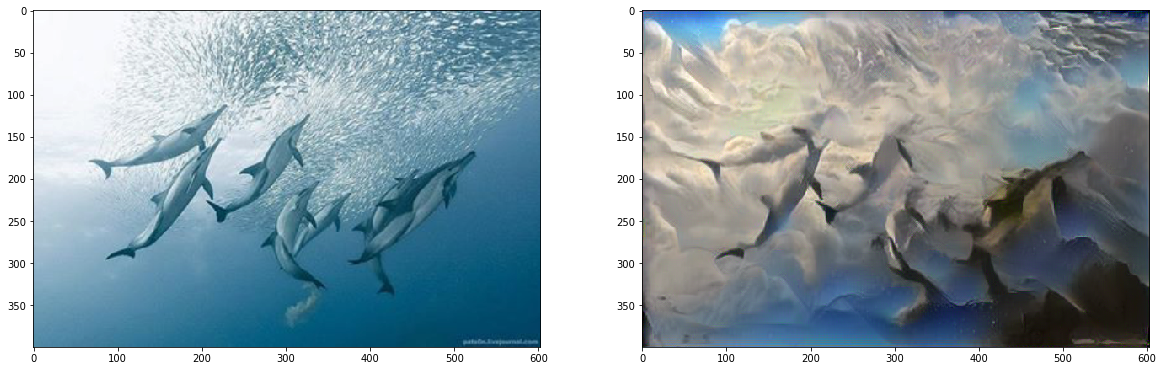

In [18]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))